In [1]:
%pip install ../../mlrose/
import mlrose_hiive as mlrose
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from ucimlrepo import fetch_ucirepo 
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score

Processing /Users/VivianNTran/Documents/CS7641 - ML/Assignment 2/mlrose
  Preparing metadata (setup.py) ... done
  Created wheel for mlrose-hiive: filename=mlrose_hiive-2.2.4-py3-none-any.whl size=103036 sha256=b19f89590e3657062bae6eca17911cd6cf55e22c2f4dcb3f9db8a3ce4935c58c
  Stored in directory: /private/var/folders/rk/9q8_q_l50ls0c1pdxg38z9m80000gp/T/pip-ephem-wheel-cache-d5o7drwk/wheels/6d/5b/da/7cf5d7915d22f9006694bfefef2b605b6ed6540017cd5e1e1a
Successfully built mlrose-hiive
  Attempting uninstall: mlrose-hiive
    Found existing installation: mlrose-hiive 2.2.4
    Uninstalling mlrose-hiive-2.2.4:
      Successfully uninstalled mlrose-hiive-2.2.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
RANDOM_STATE=101
seeds = [1, 7, 9, 101, 127]

In [3]:
# Wine Quality Data
# fetch dataset 
wq_df = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = wq_df.data.features 
y = wq_df.data.targets 

# Change values to 0-1: 0 for benign and 1 for malignant
y['Diagnosis'] = y['Diagnosis'].map({'M': 1, 'B': 0})

In [4]:
# Split into training and testing sets. Don't use test set until the very end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE, stratify = y)

### Pre-Processing

In [5]:
# Standardize training and test set
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train, y_train)

### Improved Back Propagation

#### Prediction

In [31]:
# Neural Network - Back Propogation - Reimplemented with mlrose
avg_bp_time = []
avg_bp_test_f1 = []
avg_bp_train_f1 = []
avg_bp_fitness = []
avg_train_sizes = []
avg_train_scores = []
avg_validation_scores = []

for seed in seeds:
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
                                     algorithm = 'gradient_descent', max_iters = 2000,
                                     bias = True, is_classifier = True, learning_rate = 0.001,
                                     early_stopping = True, max_attempts = 10,
    				 random_state = seed, curve = True)

    # Get time
    start_time = time.time()
    nn_model1.fit(X_train, y_train)
    end_time = time.time()
    bp_time = end_time - start_time
    avg_bp_time.append(bp_time)

    # Predict labels for train set and assess f1
    y_train_pred = nn_model1.predict(X_train)
    y_train_f1 = f1_score(y_train, y_train_pred)
    # print('Training f1: ', y_train_f1)
    avg_bp_train_f1.append(y_train_f1)

    # Predict labels for test set and assess f1
    y_test_pred = nn_model1.predict(X_test)
    y_test_f1 = f1_score(y_test, y_test_pred)
    # print('Test f1: ', y_test_f1)
    avg_bp_test_f1.append(y_test_f1)

    # Get fitness
    fitness_curve_bp = nn_model1.fitness_curve
    avg_bp_fitness.append(fitness_curve_bp)

    # Get learning curve
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = nn_model1,
    X = X_train,
    y = y_train, cv = 5,
    scoring = 'f1_macro',
    random_state=seed)

    avg_train_sizes.append(train_sizes)
    avg_train_scores.append(train_scores)
    avg_validation_scores.append(validation_scores)

In [9]:
# Run time
avg_bp_time = np.mean(avg_bp_time)
print('Avg Run Time: ', avg_bp_time)

# Training performance
avg_bp_train_f1 = np.mean(avg_bp_train_f1)
print('Avg Training Performance: ', avg_bp_train_f1)

# Testing performance
avg_bp_test_f1 = np.mean(avg_bp_test_f1)
print('Avg Test Performance: ', avg_bp_test_f1)

Avg Run Time:  8.72677903175354
Avg Training Performance:  0.9964788732394366
Avg Test Performance:  0.9360403492923817


In [10]:
# Hidden Layer = 100
# Avg Run Time:  8.956750774383545
# Avg Training Performance:  0.9968316047426917
# Avg Test Performance:  0.9317588329832429
# Hidden Layer = 75
# Avg Run Time:  10.77319793701172
# Avg Training Performance:  0.9964788732394366
# Avg Test Performance:  0.9360403492923817

#### Fitness Curve

In [34]:
# Fitness Curve
avg_bp_fitness = np.mean(avg_bp_fitness, axis=0)
std_bp_fitness = np.std(avg_bp_fitness, axis=0)
print('Avg Fitness Curve: ', avg_bp_fitness)

Avg Fitness Curve:  [-2.91550807 -4.89345586 -1.93401875 ... -0.01897629 -0.01896998
 -0.01895991]


In [35]:
# Make curve into a loss curve
avg_bp_fitness = avg_bp_fitness * -1

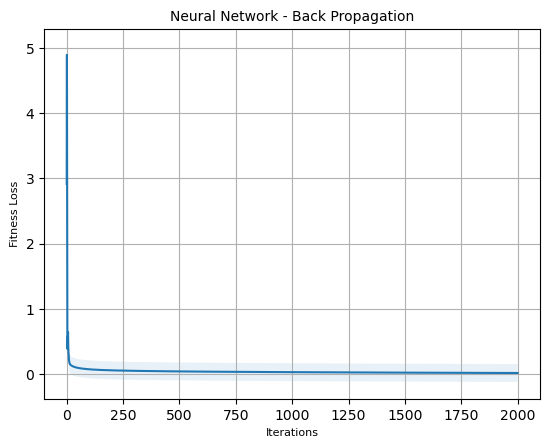

In [36]:
# Plotting fitness curve
iterations = [*range(0, len(avg_bp_fitness))]
plt.plot(iterations, avg_bp_fitness)
plt.fill_between(iterations, avg_bp_fitness - std_bp_fitness, avg_bp_fitness + std_bp_fitness, alpha=0.1)
plt.title('Neural Network - Back Propagation', fontsize=10)
plt.xlabel('Iterations', fontsize=8)
plt.ylabel('Fitness Loss', fontsize=8)
plt.grid()
plt.savefig('plots/nn_bp_fitness_iterations.png', dpi=1200)
plt.show()

#### Learning Curve

In [32]:
avg_train_sizes = np.mean(avg_train_sizes, axis=0)
std_train_scores = np.std(np.mean(avg_train_scores, axis=0), axis=1)
avg_train_scores = np.mean(np.mean(avg_train_scores, axis=0), axis=1)
std_validation_scores = np.std(np.mean(avg_validation_scores, axis=0), axis=1)
avg_validation_scores = np.mean(np.mean(avg_validation_scores, axis=0), axis=1)

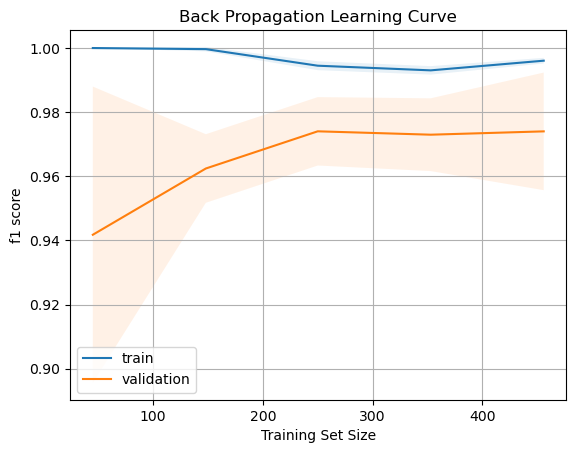

In [37]:
plt.plot(avg_train_sizes, avg_train_scores, label="train")
plt.fill_between(avg_train_sizes, avg_train_scores - std_train_scores, avg_train_scores + std_train_scores, alpha=0.1)
plt.plot(avg_train_sizes, avg_validation_scores, label="validation")
plt.fill_between(avg_train_sizes, avg_validation_scores - std_validation_scores, avg_validation_scores + std_validation_scores, alpha=0.1)

plt.title("Back Propagation Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("f1 score")
plt.legend(loc="best")
plt.grid()
plt.savefig('plots/nn_bp_learning_curve.png', dpi=1200)
plt.show()

### Random Hill Climbing

#### Prediction

In [42]:
# Neural Network - Random Hill Climbing
avg_rhc_time = []
avg_rhc_test_f1 = []
avg_rhc_train_f1 = []
avg_rhc_fitness = []
avg_train_sizes = []
avg_train_scores = []
avg_validation_scores = []

for seed in seeds:
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
                                     algorithm = 'random_hill_climb', max_iters = 2000,
                                     bias = True, is_classifier = True, learning_rate = 0.001,
                                     early_stopping = True, max_attempts = 10,
    				 random_state = seed, curve = True, restarts = 100)

    # Get time
    start_time = time.time()
    nn_model1.fit(X_train, y_train)
    end_time = time.time()
    rhc_time = end_time - start_time
    avg_rhc_time.append(rhc_time)

    # Predict labels for train set and assess f1
    y_train_pred = nn_model1.predict(X_train)
    y_train_f1 = f1_score(y_train, y_train_pred)
    print('Training f1: ', y_train_f1)
    avg_rhc_train_f1.append(y_train_f1)

    # Predict labels for test set and assess f1
    y_test_pred = nn_model1.predict(X_test)
    y_test_f1 = f1_score(y_test, y_test_pred)
    print('Test f1: ', y_test_f1)
    avg_rhc_test_f1.append(y_test_f1)

    # Get fitness
    fitness_curve_rhc = nn_model1.fitness_curve
    avg_rhc_fitness.append(fitness_curve_rhc)

    # Get learning curve
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = nn_model1,
    X = X_train,
    y = y_train, cv = 5,
    scoring = 'f1_macro',
    random_state=seed,
    n_jobs = -1)

    avg_train_sizes.append(train_sizes)
    avg_train_scores.append(train_scores)
    avg_validation_scores.append(validation_scores)

Training f1:  0.9163763066202091
Test f1:  0.8387096774193549
Training f1:  0.9042904290429042
Test f1:  0.8541666666666666
Training f1:  0.87279843444227
Test f1:  0.9090909090909091
Training f1:  0.7796101949025487
Test f1:  0.6371681415929203
Training f1:  0.8330464716006885
Test f1:  0.7526881720430108


In [43]:
# Run time
avg_rhc_time = np.mean(avg_rhc_time)
print('Avg Run Time: ', avg_rhc_time)

# Training performance
avg_rhc_train_f1 = np.mean(avg_rhc_train_f1)
print('Avg Training Performance: ', avg_rhc_train_f1)

# Testing performance
avg_rhc_test_f1 = np.mean(avg_rhc_test_f1)
print('Avg Test Performance: ', avg_rhc_test_f1)

Avg Run Time:  2261.8317960262298
Avg Training Performance:  0.8612243673217241
Avg Test Performance:  0.7983647133625723


In [44]:
# Restarts = 0
# Avg Run Time:  1.7058753490447998
# Avg Training Performance:  0.26422309552599754
# Avg Test Performance:  0.21962621222107143
# Restarts = 50
# Avg Run Time:  84.4387830734253
# Avg Training Performance:  0.8175758236156131
# Avg Test Performance:  0.7471946148665414
# Restarts = 100
# Avg Run Time:  123.76219053268433
# Avg Training Performance:  0.8612243673217241
# Avg Test Performance:  0.7983647133625723
# Restarts = 500
# Restarts = 1000

#### Fitness Curve

In [90]:
# Padding
padded_avg_rhc_fitness = []
for i in range(len(avg_rhc_fitness)):
    add_on = np.tile(avg_rhc_fitness[i][:,0][-1], ((2000 - len(avg_rhc_fitness[i][:,0]))))
    combined = np.concatenate((avg_rhc_fitness[i][:,0], add_on))
    print(combined)
    padded_avg_rhc_fitness.append(combined)

[0.744679   0.744679   0.744679   ... 0.74056601 0.74056601 0.74056601]
[0.72563426 0.72563426 0.72563426 ... 0.70897231 0.70897231 0.70897231]
[0.34528565 0.34526056 0.34526056 ... 0.34425815 0.34425815 0.34425815]
[1.39554086 1.39554081 1.39554081 ... 1.39061822 1.39061822 1.39061822]
[0.90624217 0.90620626 0.90620626 ... 0.89699485 0.89699485 0.89699485]


In [91]:
# Fitness Curve
pad_std_rhc_fitness = np.std(np.array(padded_avg_rhc_fitness), axis=0)
pad_avg_rhc_fitness = np.mean(np.array(padded_avg_rhc_fitness), axis=0)

print('Avg Fitness Curve: ', pad_avg_rhc_fitness)

Avg Fitness Curve:  [0.82347639 0.82346418 0.82346418 ... 0.81628191 0.81628191 0.81628191]


In [92]:
# # Make curve into a loss curve
# avg_bp_fitness = avg_bp_fitness * -1

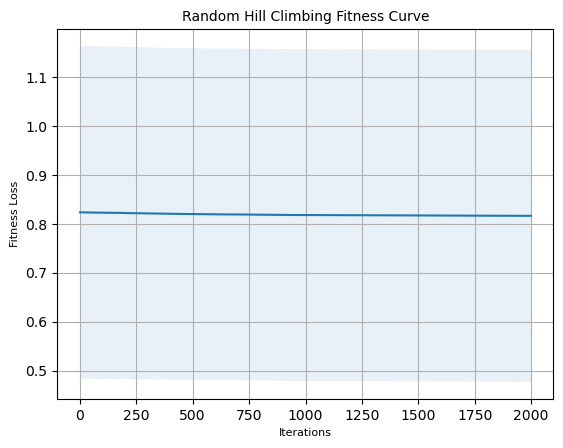

In [94]:
# # Plotting fitness curve
# iterations = [*range(0, len(pad_avg_rhc_fitness))]
# plt.plot(iterations, pad_avg_rhc_fitness)
# plt.fill_between(iterations, pad_avg_rhc_fitness - pad_std_rhc_fitness, pad_avg_rhc_fitness + pad_std_rhc_fitness, alpha=0.1)
# plt.title('Random Hill Climbing Fitness Curve', fontsize=10)
# plt.xlabel('Iterations', fontsize=8)
# plt.ylabel('Fitness Loss', fontsize=8)
# plt.grid()
# plt.savefig('plots/nn_rhc_fitness_iterations.png', dpi=1200)
# plt.show()

#### Learning Curve

In [75]:
# avg_train_sizes = np.mean(avg_train_sizes, axis=0)
# std_train_scores = np.std(np.mean(avg_train_scores, axis=0), axis=1)
# avg_train_scores = np.mean(np.mean(avg_train_scores, axis=0), axis=1)
# std_validation_scores = np.std(np.mean(avg_validation_scores, axis=0), axis=1)
# avg_validation_scores = np.mean(np.mean(avg_validation_scores, axis=0), axis=1)

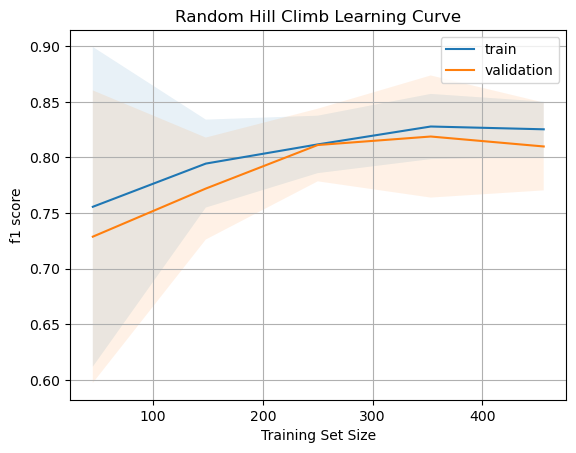

In [76]:
# plt.plot(avg_train_sizes, avg_train_scores, label="train")
# plt.fill_between(avg_train_sizes, avg_train_scores - std_train_scores, avg_train_scores + std_train_scores, alpha=0.1)
# plt.plot(avg_train_sizes, avg_validation_scores, label="validation")
# plt.fill_between(avg_train_sizes, avg_validation_scores - std_validation_scores, avg_validation_scores + std_validation_scores, alpha=0.1)

# plt.title("Random Hill Climb Learning Curve")
# plt.xlabel("Training Set Size")
# plt.ylabel("f1 score")
# plt.legend(loc="best")
# plt.grid()
# plt.savefig('plots/nn_rhc_learning_curve.png')
# plt.show()

#### Validation Curves

In [39]:
# parameter_range = [1, 10, 25, 50, 100, 200]
# val_avg_train_scores = []
# val_avg_test_scores = []

# nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
#                                  algorithm = 'random_hill_climb', max_iters = 2000,
#                                  bias = True, is_classifier = True, learning_rate = 0.001,
#                                  early_stopping = True, max_attempts = 10,
#                  random_state = seed, curve = True)

# train_score, test_score = validation_curve(nn_model1, X_train, y_train,
#                                            param_name="restarts",
#                                            param_range=parameter_range,
#                                            cv=5, scoring="f1_macro")

# val_avg_train_scores.append(train_score)
# val_avg_test_scores.append(test_score)

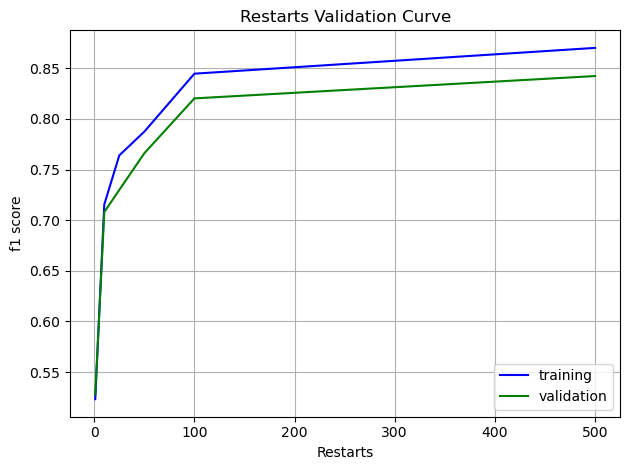

In [41]:
# # Calculating mean and standard deviation of training score
# mean_train_score = np.mean(train_score, axis=1)
# std_train_score = np.std(train_score, axis=1)
 
# # Calculating mean and standard deviation of testing score
# mean_test_score = np.mean(test_score, axis=1)
# std_test_score = np.std(test_score, axis=1)

# parameter_range = [1, 10, 25, 50, 100, 500]
# # Plot mean accuracy scores for training and testing scores
# plt.plot(parameter_range, mean_train_score,
#          label="training", color='b')
# # plt.fill_between(parameter_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.1)
# plt.plot(parameter_range, mean_test_score,
#          label="validation", color='g')
# # plt.fill_between(parameter_range, mean_test_score - std_test_score, mean_test_score + std_test_score, alpha=0.1)
 
# # Creating the plot
# plt.title("Restarts Validation Curve")
# plt.xlabel("Restarts")
# plt.ylabel("f1 score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.grid()
# plt.savefig('plots/nn_rhc_restarts_validation_curve.png', dpi=1200)
# plt.show()

### Simulated Annealing

#### Prediction

In [98]:
# Neural Network - Simulated Annealing
avg_sa_time = []
avg_sa_test_f1 = []
avg_sa_train_f1 = []
avg_sa_fitness = []
avg_train_sizes = []
avg_train_scores = []
avg_validation_scores = []

for seed in seeds:
    schedule = mlrose.GeomDecay()
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
                                     algorithm = 'simulated_annealing', max_iters = 2000,
                                     bias = True, is_classifier = True, learning_rate = 0.001,
                                     early_stopping = True, max_attempts = 10,
    				 random_state = seed, curve = True, schedule = schedule)

    # Get time
    start_time = time.time()
    nn_model1.fit(X_train, y_train)
    end_time = time.time()
    sa_time = end_time - start_time
    avg_sa_time.append(sa_time)

    # Predict labels for train set and assess f1
    y_train_pred = nn_model1.predict(X_train)
    y_train_f1 = f1_score(y_train, y_train_pred)
    print('Training f1: ', y_train_f1)
    avg_sa_train_f1.append(y_train_f1)

    # Predict labels for test set and assess f1
    y_test_pred = nn_model1.predict(X_test)
    y_test_f1 = f1_score(y_test, y_test_pred)
    print('Test f1: ', y_test_f1)
    avg_sa_test_f1.append(y_test_f1)

    # Get fitness
    fitness_curve_sa = nn_model1.fitness_curve
    avg_sa_fitness.append(fitness_curve_sa)

    # Get learning curve
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = nn_model1,
    X = X_train,
    y = y_train, cv = 5,
    scoring = 'f1_macro',
    random_state=seed,
    n_jobs = -1)

    avg_train_sizes.append(train_sizes)
    avg_train_scores.append(train_scores)
    avg_validation_scores.append(validation_scores)

Training f1:  0.020833333333333332
Test f1:  0.046511627906976744
Training f1:  0.0
Test f1:  0.0
Training f1:  0.6369119420989143
Test f1:  0.5131578947368421
Training f1:  0.6666666666666666
Test f1:  0.5384615384615384
Training f1:  0.0
Test f1:  0.0


In [78]:
# Run time
avg_sa_time = np.mean(avg_sa_time)
print('Avg Run Time: ', avg_sa_time)

# Training performance
avg_sa_train_f1 = np.mean(avg_sa_train_f1)
print('Avg Training Performance: ', avg_sa_train_f1)

# Testing performance
avg_sa_test_f1 = np.mean(avg_sa_test_f1)
print('Avg Test Performance: ', avg_sa_test_f1)

Avg Run Time:  160.30790300369262
Avg Training Performance:  0.2648823884197829
Avg Test Performance:  0.21962621222107143


In [ ]:
# Default
# Avg Run Time:  5.472656869888306
# Avg Training Performance:  0.2648823884197829
# Avg Test Performance:  0.21962621222107143

#### Fitness Curve

In [83]:
fitness_sa_values = []
for i in range(len(avg_sa_fitness)):
    fitness_sa_values.append(avg_sa_fitness[i][:,0])

In [85]:
print(np.mean(np.array(fitness_sa_values), axis=0))

[2.91553657 2.91565375 2.91567007 ... 2.91043538 2.91043796 2.91043355]


In [86]:
# Fitness Curve
std_sa_fitness_curve = np.std(np.array(fitness_sa_values), axis=0)
avg_sa_fitness_curve = np.mean(np.array(fitness_sa_values), axis=0)
print('Avg Fitness Curve: ', avg_sa_fitness_curve)

Avg Fitness Curve:  [2.91553657 2.91565375 2.91567007 ... 2.91043538 2.91043796 2.91043355]


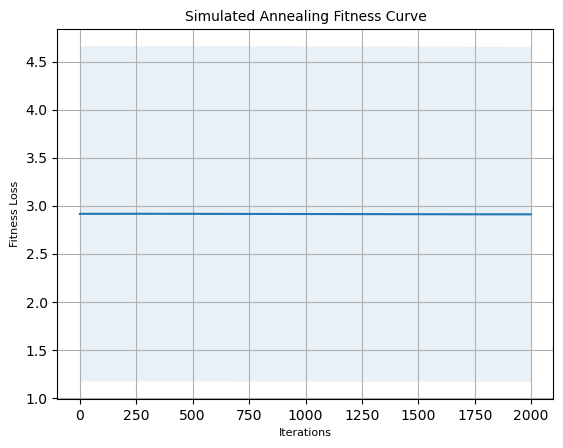

In [89]:
# Plotting fitness curve
iterations = [*range(0, len(avg_sa_fitness_curve))]
plt.plot(iterations, avg_sa_fitness_curve)
plt.fill_between(iterations, avg_sa_fitness_curve - std_sa_fitness_curve, avg_sa_fitness_curve + std_sa_fitness_curve, alpha=0.1)
plt.title('Simulated Annealing Fitness Curve', fontsize=10)
plt.xlabel('Iterations', fontsize=8)
plt.ylabel('Fitness Loss', fontsize=8)
plt.grid()
plt.savefig('plots/nn_sa_fitness_iterations.png')
plt.show()

#### Learning Curve

In [99]:
# avg_train_sizes = np.mean(avg_train_sizes, axis=0)
# std_train_scores = np.std(np.mean(avg_train_scores, axis=0), axis=1)
# avg_train_scores = np.mean(np.mean(avg_train_scores, axis=0), axis=1)
# std_validation_scores = np.std(np.mean(avg_validation_scores, axis=0), axis=1)
# avg_validation_scores = np.mean(np.mean(avg_validation_scores, axis=0), axis=1)

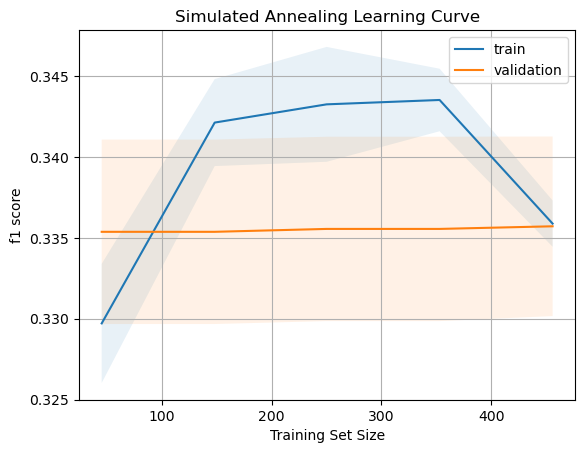

In [100]:
# plt.plot(avg_train_sizes, avg_train_scores, label="train")
# plt.fill_between(avg_train_sizes, avg_train_scores - std_train_scores, avg_train_scores + std_train_scores, alpha=0.1)
# plt.plot(avg_train_sizes, avg_validation_scores, label="validation")
# plt.fill_between(avg_train_sizes, avg_validation_scores - std_validation_scores, avg_validation_scores + std_validation_scores, alpha=0.1)

# plt.title("Simulated Annealing Learning Curve")
# plt.xlabel("Training Set Size")
# plt.ylabel("f1 score")
# plt.legend(loc="best")
# plt.grid()
# plt.savefig('plots/nn_sa_learning_curve.png')
# plt.show()

#### Validation Curve

In [ ]:
# parameter_range = [mlrose.GeomDecay(init_temp=1), mlrose.GeomDecay(init_temp=25), mlrose.GeomDecay(init_temp=50), mlrose.GeomDecay(init_temp=100)]
# nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
#                                  algorithm = 'simulated_annealing', max_iters = 2000,
#                                  bias = True, is_classifier = True, learning_rate = 0.001,
#                                  early_stopping = True, max_attempts = 10,
# 				 random_state = seed, curve = True)

# init_temp_train_score, init_temp_test_score = validation_curve(nn_model1, X_train, y_train,
#                                            param_name="schedule",
#                                            param_range=parameter_range,
#                                            cv=5, scoring="f1_macro", n_jobs=-1)

In [ ]:
# # Calculating mean and standard deviation of training score
# mean_init_temp_train_score = np.mean(init_temp_train_score, axis=1)
 
# # Calculating mean and standard deviation of testing score
# mean_init_temp_test_score = np.mean(init_temp_test_score, axis=1)

# parameter_range = [1, 25, 50, 100]
# # Plot mean accuracy scores for training and testing scores
# plt.plot(parameter_range, mean_init_temp_train_score,
#          label="training", color='b')
# plt.plot(parameter_range, mean_init_temp_test_score,
#          label="validation", color='g')
 
# # Creating the plot
# plt.title("Init Temp Validation Curve")
# plt.xlabel("Init Temp")
# plt.ylabel("f1 score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.grid()
# plt.savefig('plots/nn_sa_init_temp_validation_curve.png')
# plt.show()

In [ ]:
# parameter_range = [mlrose.GeomDecay(decay=.1), mlrose.GeomDecay(decay=.25), mlrose.GeomDecay(decay=.5), mlrose.GeomDecay(decay=.99)]
# nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
#                                  algorithm = 'simulated_annealing', max_iters = 2000,
#                                  bias = True, is_classifier = True, learning_rate = 0.001,
#                                  early_stopping = True, max_attempts = 10,
# 				 random_state = seed, curve = True)
# decay_train_score, decay_test_score = validation_curve(nn_model1, X_train, y_train,
#                                            param_name="schedule",
#                                            param_range=parameter_range,
#                                            cv=5, scoring="f1_macro", n_jobs=-1)

In [ ]:
# # Calculating mean and standard deviation of training score
# mean_decay_train_score = np.mean(decay_train_score, axis=1)
 
# # Calculating mean and standard deviation of testing score
# mean_decay_test_score = np.mean(decay_test_score, axis=1)

# parameter_range = [.1, .25, .50, .99]
# # Plot mean accuracy scores for training and testing scores
# plt.plot(parameter_range, mean_decay_train_score,
#          label="training", color='b')
# plt.plot(parameter_range, mean_decay_test_score,
#          label="validation", color='g')
 
# # Creating the plot
# plt.title("Decay Validation Curve")
# plt.xlabel("Decay Temp")
# plt.ylabel("f1 score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.grid()
# plt.savefig('plots/nn_sa_decay_validation_curve.png')
# plt.show()

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

# parameter_range1 = [.1, .25, .50, 1]
# parameter_range2 = [.1, .25, .50, .99]

# ax1.plot(parameter_range1, mean_init_temp_train_score,
#          label="training", color='b')
# ax1.plot(parameter_range1, mean_init_temp_test_score,
#          label="validation", color='g')
# ax1.set_title("Initial Temperature Validation Curve", fontsize=10)
# ax1.set_xlabel("Initial Temperature", fontsize=8)
# ax1.set_ylabel("f1 score", fontsize=8)
# ax1.legend(loc='best')
# ax1.grid()

# ax2.plot(parameter_range2, mean_decay_train_score,
#          label="training", color='b')
# ax2.plot(parameter_range2, mean_decay_test_score,
#          label="validation", color='g')
# ax2.set_title("Decay Validation Curve", fontsize=10)
# ax2.set_xlabel("Decay", fontsize=8)
# ax2.set_ylabel("f1 score", fontsize=8)
# ax2.legend(loc='best')
# ax2.grid()

# fig.tight_layout(pad = 1.5)
# plt.savefig('plots/nn_sa_validation_curves.png')
# plt.show()

### Genetic Algorithm

#### Prediction

In [101]:
# Neural Network - Genetic Algorithm
avg_ga_time = []
avg_ga_test_f1 = []
avg_ga_train_f1 = []
avg_ga_fitness = []
avg_train_sizes = []
avg_train_scores = []
avg_validation_scores = []

for seed in seeds:
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
                                     algorithm = 'genetic_alg', max_iters = 2000,
                                     bias = True, is_classifier = True, learning_rate = 0.001,
                                     early_stopping = True, max_attempts = 10,
    				 random_state = seed, curve = True, pop_size = 850, mutation_prob=.1)

    # Get time
    start_time = time.time()
    nn_model1.fit(X_train, y_train)
    end_time = time.time()
    ga_time = end_time - start_time
    avg_ga_time.append(ga_time)

    # Predict labels for train set and assess f1
    y_train_pred = nn_model1.predict(X_train)
    y_train_f1 = f1_score(y_train, y_train_pred)
    print('Training f1: ', y_train_f1)
    avg_ga_train_f1.append(y_train_f1)

    # Predict labels for test set and assess f1
    y_test_pred = nn_model1.predict(X_test)
    y_test_f1 = f1_score(y_test, y_test_pred)
    print('Test f1: ', y_test_f1)
    avg_ga_test_f1.append(y_test_f1)

    # Get fitness
    fitness_curve_ga = nn_model1.fitness_curve
    avg_ga_fitness.append(fitness_curve_ga)

    # Get learning curve
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = nn_model1,
    X = X_train,
    y = y_train, cv = 5,
    scoring = 'f1_macro',
    random_state=seed,
    n_jobs = -1)

    avg_train_sizes.append(train_sizes)
    avg_train_scores.append(train_scores)
    avg_validation_scores.append(validation_scores)

Training f1:  0.9587628865979382
Test f1:  0.8888888888888888
Training f1:  0.9513513513513514
Test f1:  0.9024390243902439
Training f1:  0.9451327433628318
Test f1:  0.8409090909090909
Training f1:  0.9541595925297114
Test f1:  0.8571428571428571
Training f1:  0.9703315881326352
Test f1:  0.9156626506024096


In [102]:
# Run time
avg_ga_time = np.mean(avg_ga_time)
print('Avg Run Time: ', avg_ga_time)

# Training performance
avg_ga_train_f1 = np.mean(avg_ga_train_f1)
print('Avg Training Performance: ', avg_ga_train_f1)

# Testing performance
avg_ga_test_f1 = np.mean(avg_ga_test_f1)
print('Avg Test Performance: ', avg_ga_test_f1)

Avg Run Time:  114.15988893508911
Avg Training Performance:  0.9559476323948936
Avg Test Performance:  0.881008502386698


In [ ]:
# Pop Size: 850, Mutation Prob: .1
# Avg Run Time:  41.921142721176146
# Avg Training Performance:  0.9559476323948936
# Avg Test Performance:  0.881008502386698

#### Fitness Curve

In [106]:
# Padding
padded_avg_ga_fitness = []
for i in range(len(avg_ga_fitness)):
    add_on = np.tile(avg_ga_fitness[i][:,0][-1], ((2000 - len(avg_ga_fitness[i][:,0]))))
    combined = np.concatenate((avg_ga_fitness[i][:,0], add_on))
    print(combined)
    padded_avg_ga_fitness.append(combined)

[2.65584814 2.65584814 2.65584814 ... 1.51762751 1.51762751 1.51762751]
[3.0984895  3.0984895  3.0984895  ... 1.70733095 1.70733095 1.70733095]
[1.96026887 1.96026887 1.96026887 ... 1.96026887 1.96026887 1.96026887]
[3.4146619  3.4146619  2.97202054 ... 1.70733095 1.70733095 1.70733095]
[3.47789638 3.47789638 3.03525502 ... 1.07498615 1.07498615 1.07498615]


In [107]:
# Fitness Curve
pad_std_ga_fitness = np.std(np.array(padded_avg_ga_fitness), axis=0)
pad_avg_ga_fitness = np.mean(np.array(padded_avg_ga_fitness), axis=0)

print('Avg Fitness Curve: ', pad_avg_ga_fitness)

Avg Fitness Curve:  [2.92143296 2.92143296 2.74437642 ... 1.59350889 1.59350889 1.59350889]


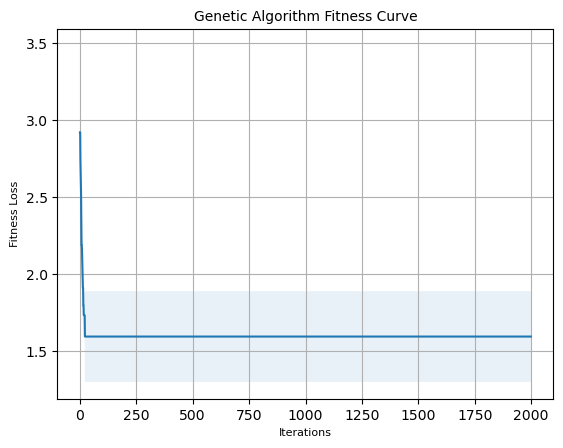

In [109]:
# Plotting fitness curve
iterations = [*range(0, len(pad_avg_ga_fitness))]
plt.plot(iterations, pad_avg_ga_fitness)
plt.fill_between(iterations, pad_avg_ga_fitness - pad_std_ga_fitness, pad_avg_ga_fitness + pad_std_ga_fitness, alpha=0.1)
plt.title('Genetic Algorithm Fitness Curve', fontsize=10)
plt.xlabel('Iterations', fontsize=8)
plt.ylabel('Fitness Loss', fontsize=8)
plt.grid()
plt.savefig('plots/nn_ga_fitness_iterations.png', dpi=1200)
plt.show()

#### Learning Curve

In [110]:
avg_train_sizes = np.mean(avg_train_sizes, axis=0)
std_train_scores = np.std(np.mean(avg_train_scores, axis=0), axis=1)
avg_train_scores = np.mean(np.mean(avg_train_scores, axis=0), axis=1)
std_validation_scores = np.std(np.mean(avg_validation_scores, axis=0), axis=1)
avg_validation_scores = np.mean(np.mean(avg_validation_scores, axis=0), axis=1)

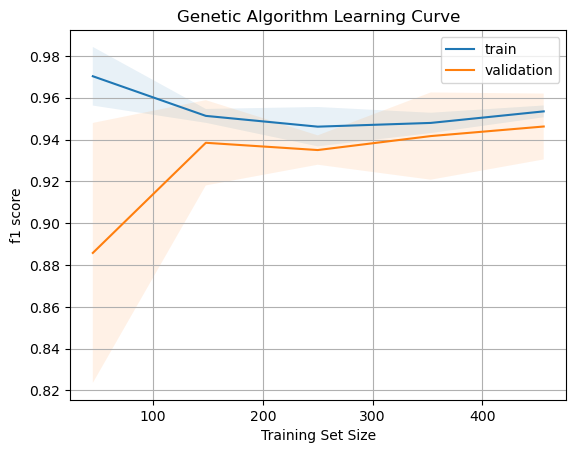

In [111]:
plt.plot(avg_train_sizes, avg_train_scores, label="train")
plt.fill_between(avg_train_sizes, avg_train_scores - std_train_scores, avg_train_scores + std_train_scores, alpha=0.1)
plt.plot(avg_train_sizes, avg_validation_scores, label="validation")
plt.fill_between(avg_train_sizes, avg_validation_scores - std_validation_scores, avg_validation_scores + std_validation_scores, alpha=0.1)

plt.title("Genetic Algorithm Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("f1 score")
plt.legend(loc="best")
plt.grid()
plt.savefig('plots/nn_ga_learning_curve.png', dpi=1200)
plt.show()

#### Validation Curves

In [ ]:
# parameter_range = [10, 50, 100, 150, 200, 500, 1000]

# nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
#                                  algorithm = 'genetic_alg', max_iters = 2000,
#                                  bias = True, is_classifier = True, learning_rate = 0.001,
#                                  early_stopping = True, max_attempts = 10,
# 				 random_state = seed, curve = True)
# pop_size_train_score, pop_size_test_score = validation_curve(nn_model1, X_train, y_train,
#                                            param_name="pop_size",
#                                            param_range=parameter_range,
#                                            cv=5, scoring="f1_macro",
#                                           n_jobs=-1)

In [ ]:
# # Calculating mean and standard deviation of training score
# mean_pop_size_train_score = np.mean(pop_size_train_score, axis=1)
 
# # Calculating mean and standard deviation of testing score
# mean_pop_size_test_score = np.mean(pop_size_test_score, axis=1)

# parameter_range = [10, 50, 100, 150, 200, 500, 1000]
# # Plot mean accuracy scores for training and testing scores
# plt.plot(parameter_range, mean_pop_size_train_score,
#          label="training", color='b')
# plt.plot(parameter_range, mean_pop_size_test_score,
#          label="validation", color='g')
 
# # Creating the plot
# plt.title("Pop Size Validation Curve")
# plt.xlabel("Pop Size")
# plt.ylabel("f1 score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.grid()
# plt.savefig('plots/nn_ga_pop_size_validation_curve.png')
# plt.show()

In [ ]:
# parameter_range = [.1, .25, .5, .75, .99]

# nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
#                                  algorithm = 'genetic_alg', max_iters = 2000,
#                                  bias = True, is_classifier = True, learning_rate = 0.001,
#                                  early_stopping = True, max_attempts = 10,
# 				 random_state = RANDOM_STATE, curve = True)
# mut_prob_train_score, mut_prob_test_score = validation_curve(nn_model1, X_train, y_train,
#                                            param_name="mutation_prob",
#                                            param_range=parameter_range,
#                                            cv=5, scoring="f1_macro",
#                                           n_jobs=-1)

In [ ]:
# # Calculating mean and standard deviation of training score
# mean_mut_prob_train_score = np.mean(mut_prob_train_score, axis=1)
 
# # Calculating mean and standard deviation of testing score
# mean_mut_prob_test_score = np.mean(mut_prob_test_score, axis=1)

# parameter_range = [.1, .25, .5, .75, .99]
# # Plot mean accuracy scores for training and testing scores
# plt.plot(parameter_range, mean_mut_prob_train_score,
#          label="training", color='b')
# plt.plot(parameter_range, mean_mut_prob_test_score,
#          label="validation", color='g')
 
# # Creating the plot
# plt.title("Mutation Prob Validation Curve")
# plt.xlabel("Mutation Prob")
# plt.ylabel("f1 score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.grid()
# plt.show()

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

# parameter_range1 = [10, 50, 100, 150, 200, 500, 1000]
# parameter_range2 = [.1, .25, .5, .75, .99]

# ax1.plot(parameter_range1, mean_pop_size_train_score,
#          label="training", color='b')
# ax1.plot(parameter_range1, mean_pop_size_test_score,
#          label="validation", color='g')
# ax1.set_title("Pop Size Validation Curve", fontsize=10)
# ax1.set_xlabel("Pop Size", fontsize=8)
# ax1.set_ylabel("f1 score", fontsize=8)
# ax1.legend(loc='best')
# ax1.grid()

# ax2.plot(parameter_range2, mean_mut_prob_train_score,
#          label="training", color='b')
# ax2.plot(parameter_range2, mean_mut_prob_test_score,
#          label="validation", color='g')
# ax2.set_title("Mutation Prob Validation Curve", fontsize=10)
# ax2.set_xlabel("Mutation Prob", fontsize=8)
# ax2.set_ylabel("f1 score", fontsize=8)
# ax2.legend(loc='best')
# ax2.grid()

# fig.tight_layout(pad = 1.5)
# plt.savefig('plots/nn_ga_validation_curves.png')
# plt.show()

In [ ]:
# parameter_range = [.1, .25, .5, .75, .99]

# nn_model1 = mlrose.NeuralNetwork(hidden_nodes = (75,), activation = 'relu',
#                                  algorithm = 'genetic_alg', max_iters = 2000,
#                                  bias = True, is_classifier = True, learning_rate = 0.001,
#                                  early_stopping = True, max_attempts = 10,
# 				 random_state = RANDOM_STATE, curve = True, pop_size=850)
# mut_prob_train_score, mut_prob_test_score = validation_curve(nn_model1, X_train, y_train,
#                                            param_name="mutation_prob",
#                                            param_range=parameter_range,
#                                            cv=5, scoring="f1_macro",
#                                           n_jobs=-1)

In [ ]:
# # Calculating mean and standard deviation of training score
# mean_mut_prob_train_score = np.mean(mut_prob_train_score, axis=1)
 
# # Calculating mean and standard deviation of testing score
# mean_mut_prob_test_score = np.mean(mut_prob_test_score, axis=1)

# parameter_range = [.1, .25, .5, .75, .99]
# # Plot mean accuracy scores for training and testing scores
# plt.plot(parameter_range, mean_mut_prob_train_score,
#          label="training", color='b')
# plt.plot(parameter_range, mean_mut_prob_test_score,
#          label="validation", color='g')
 
# # Creating the plot
# plt.title("Mutation Prob Validation Curve")
# plt.xlabel("Mutation Prob")
# plt.ylabel("f1 score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.grid()
# plt.show()

### Combined Plots

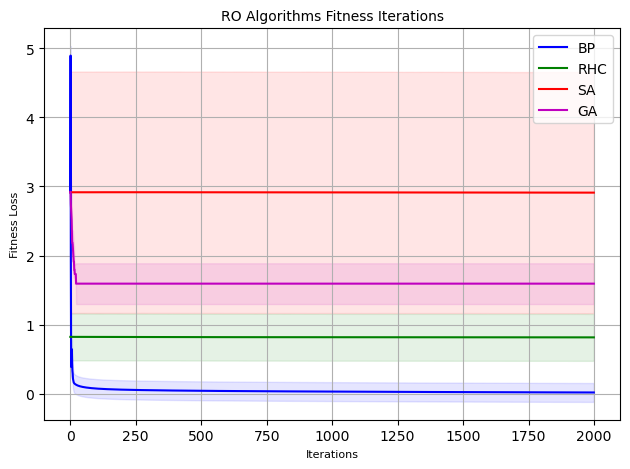

In [113]:
iterations1 = [*range(0, len(avg_bp_fitness))]
iterations2 = [*range(0, len(pad_avg_rhc_fitness))]
iterations3 = [*range(0, len(avg_sa_fitness_curve))]
iterations4 = [*range(0, len(pad_avg_ga_fitness))]

plt.plot(iterations1, avg_bp_fitness,
         label="BP", color='b')
plt.fill_between(iterations1, avg_bp_fitness - std_bp_fitness, avg_bp_fitness + std_bp_fitness, alpha=0.1, color='b')
plt.plot(iterations2, pad_avg_rhc_fitness,
         label="RHC", color='g')
plt.fill_between(iterations2, pad_avg_rhc_fitness - pad_std_rhc_fitness, pad_avg_rhc_fitness + pad_std_rhc_fitness, alpha=0.1, color='g')
plt.plot(iterations3, avg_sa_fitness_curve,
         label="SA", color='r')
plt.fill_between(iterations3, avg_sa_fitness_curve - std_sa_fitness_curve, avg_sa_fitness_curve + std_sa_fitness_curve, alpha=0.1, color='r')
plt.plot(iterations4, pad_avg_ga_fitness,
         label="GA", color='m')
plt.fill_between(iterations4, pad_avg_ga_fitness - pad_std_ga_fitness, pad_avg_ga_fitness + pad_std_ga_fitness, alpha=0.1, color='m')
plt.title("RO Algorithms Fitness Iterations", fontsize=10)
plt.xlabel("Iterations", fontsize=8)
plt.ylabel("Fitness Loss", fontsize=8)
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.savefig('plots/combined_fitness_iterations.png', dpi=1200)
plt.show()